# Fashion MNIST Classification without Data Augmentation

This notebook implements a Convolutional Neural Network (CNN) to classify Fashion MNIST dataset images without using data augmentation techniques.

## Setup and Imports

Import required libraries and set random seeds for reproducibility.

In [ ]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)
from scipy.stats import uniform, randint
from PIL import Image

INPUT_PATH = "/kaggle/input"
OUTPUT_PATH = "/kaggle/working"

if os.path.exists(INPUT_PATH):
    print("Kaggle dataset path exists.")
else:
    print("Dataset path not found. Please verify the dataset location.")


Kaggle dataset path exists.


## Data Labels

Define mapping between numeric labels and fashion item categories.

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

### Data Transformation for Training and Testing

1. **Training Transformations (Augmentation)**  
   - **Random Crop**: Pads and randomly crops the image to add variability.
   - **Horizontal Flip**: Applies a 30% chance of flipping the image.
   - **Random Rotation**: Rotates the image up to ±10 degrees.
   - **Color Jitter**: Adjusts brightness and contrast randomly.
   - **Random Affine**: Applies small translations to shift the image up to 10%.
   - **Normalization**: Standardizes the image using the Fashion-MNIST dataset's mean and standard deviation.

2. **Testing Transformations (No Augmentation)**  
   - Converts images to tensors and normalizes them for evaluation.

3. **Dataset Creation**  
   - **Training Dataset**: Applies the training transformations.
   - **Test Dataset**: Applies the test transformations for evaluation without augmentation.

4. **Purpose**  
   - The training transformations help improve model generalization by exposing it to varied input data.
   - The test transformations ensure the model is evaluated on standardized data.

In [3]:
# Training transformations - includes augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(p=0.3),  
    transforms.RandomRotation(
        degrees=10,  
        fill=0
    ),
    transforms.ColorJitter(
        brightness=0.2,  
        contrast=0.2,    
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1)  
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Fashion-MNIST mean and std
])

# Test transformations - no augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_train
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_test
)

100%|██████████| 26421880/26421880 [00:03<00:00, 8096458.79it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 132783.96it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2511824.70it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12488303.64it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Visualizing Transformed Images

1. **Function Overview**  
   - Displays a comparison of original and transformed images side by side.  
   - Uses the dataset's transformations to generate new variants of the same image.

2. **Visualization Layout**  
   - Top row: Original images with their class labels.  
   - Bottom row: Transformed versions of the same images with the same labels.

3. **Interactive Exploration**  
   - Allows inspection of the effects of data augmentation.  
   - Helps verify that transformations are applied correctly and preserve class integrity.

4. **Execution**  
   - Visualizes a subset of images from the training dataset with transformations applied.

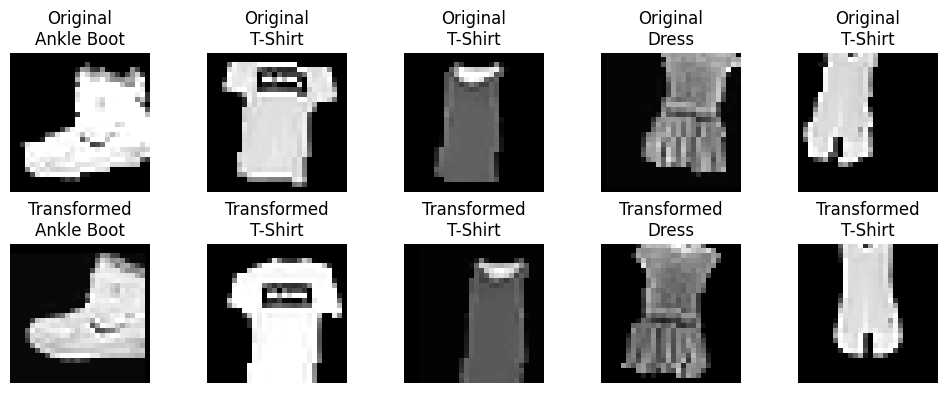

In [4]:
def show_transformed_images(dataset, num_images=5):
    figure = plt.figure(figsize=(2*num_images, 4))
    
    # Original images on top row
    for i in range(num_images):
        # Get an image
        img, label = dataset[i]
        
        # Original
        ax = figure.add_subplot(2, num_images, i + 1)
        ax.set_title(f'Original\n{labels_map[label]}')
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
        
        # Get another transform of the same image
        img, label = dataset[i]  
        
        # Transformed
        ax = figure.add_subplot(2, num_images, i + 1 + num_images)
        ax.set_title(f'Transformed\n{labels_map[label]}')
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    
    plt.tight_layout()
    plt.show()

# Visualize the transformations
show_transformed_images(training_data)

### Visualizing Dataset Characteristics

1. **Class Distribution Visualization**
   - **Purpose**: Shows the number of samples for each class in the dataset.
   - **Method**: Uses `sns.countplot` to display a count of each class label.
   - **Output**: Displays the distribution for both training and test datasets, with class labels properly mapped and rotated for readability.

2. **Sample Image Grid**
   - **Purpose**: Provides a visual overview of the dataset by displaying a grid of sample images.
   - **Method**: Creates a grid of a specified number of images with their corresponding class labels.
   - **Output**: Helps verify the dataset's image quality and the class labels visually.

Training Data Distribution:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


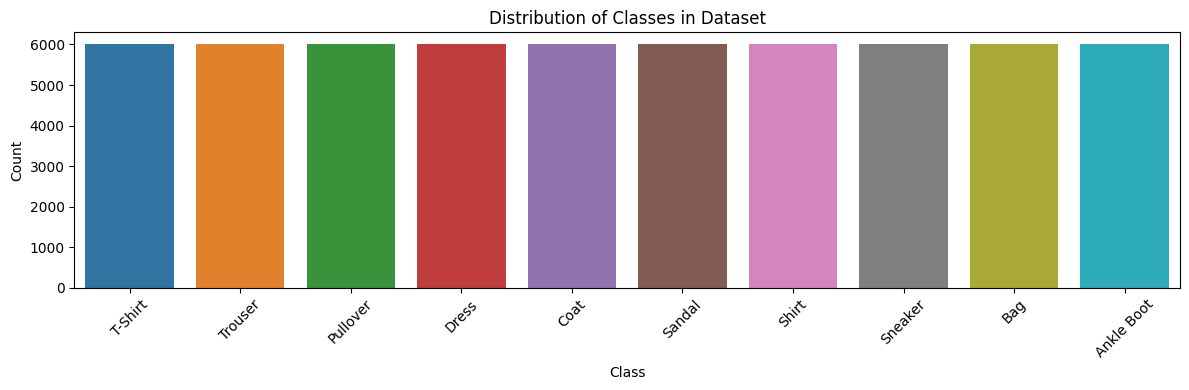


Test Data Distribution:


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


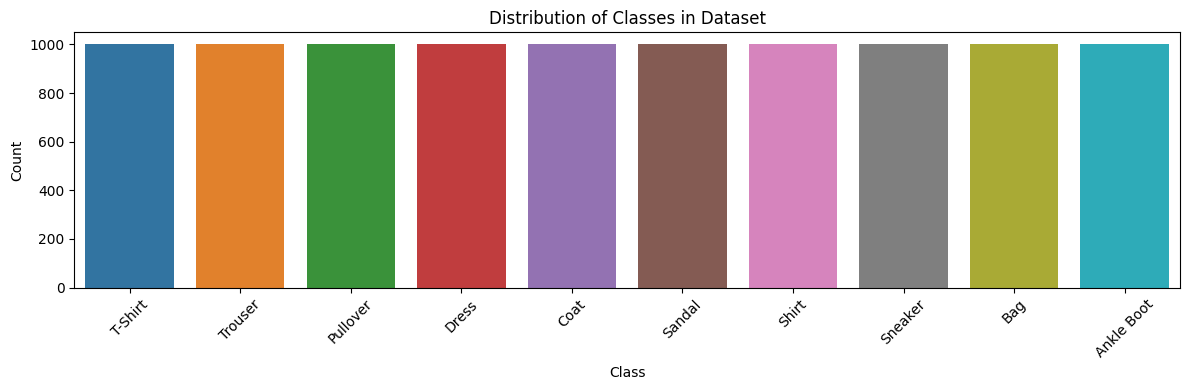

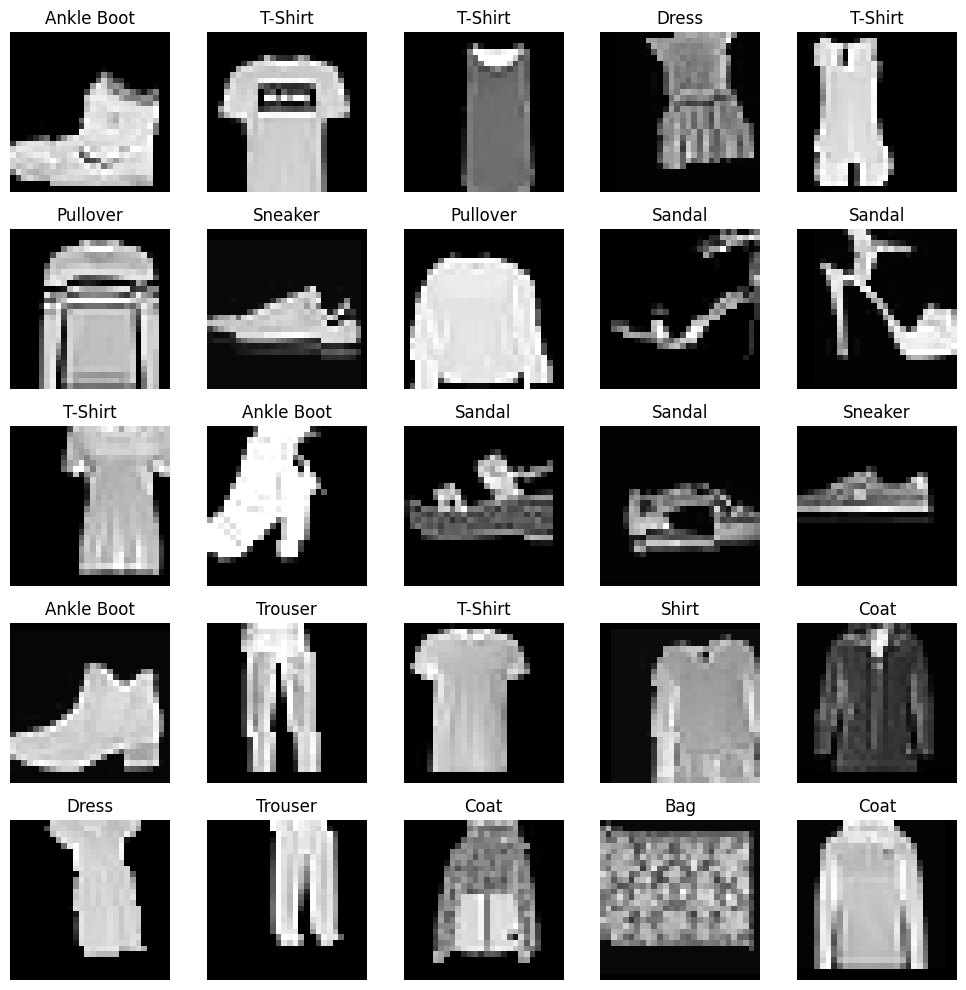

In [5]:
def show_dataset_distribution(dataset):
    # Get all labels
    labels = [label for _, label in dataset]
    
    # Create distribution plot
    plt.figure(figsize=(12, 4))
    sns.countplot(x=labels)
    plt.title('Distribution of Classes in Dataset')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(10), [labels_map[i] for i in range(10)], rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize distributions separately
print("Training Data Distribution:")
show_dataset_distribution(training_data)

print("\nTest Data Distribution:")
show_dataset_distribution(test_data)

def show_sample_grid(dataset, num_images=25):
    # Create a grid of sample images
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))
    
    figure = plt.figure(figsize=(2*cols, 2*rows))
    for i in range(num_images):
        img, label = dataset[i]
        ax = figure.add_subplot(rows, cols, i + 1)
        ax.set_title(f'{labels_map[label]}')
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    
    plt.tight_layout()
    plt.show()

show_sample_grid(training_data)

### Splitting Dataset and Creating Data Loaders

1. **Batch Size and Validation Split**  
   - Defined a batch size of 64 for data loaders.  
   - Used 20% of the dataset for validation (`validation_split = 0.2`).

2. **Calculating Dataset Sizes**  
   - Computed the size of the training and validation datasets based on the total dataset length.

3. **Dataset Splitting**  
   - Divided the training dataset into two parts: training and validation sets using `random_split`.

4. **Data Loaders Creation**  
   - Created three data loaders for:
     - **Training Data**: Shuffled with pin memory and 2 workers.  
     - **Validation Data**: Non-shuffled with similar settings.  
     - **Test Data**: For evaluation purposes with similar settings.

In [6]:
batch_size = 64
validation_split = 0.2 

dataset_size = len(training_data)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(
    training_data, 
    [train_size, val_size]
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_data, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_data)}")
print(f"\nBatch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training set size: 48000
Validation set size: 12000
Test set size: 10000

Batch size: 64
Training batches: 750
Validation batches: 188
Test batches: 157


### FashionCNN Architecture Summary

1. **Convolutional Blocks**  
   - **Three blocks** with convolution, batch normalization, ReLU activation, max pooling, and dropout layers.  
   - Reduces spatial dimensions and extracts hierarchical features.

2. **Fully Connected Layers**  
   - Flattens the output from the convolutional blocks.  
   - Includes two dense layers with ReLU activation and dropout for regularization.  
   - Outputs predictions for 10 classes.

3. **Model Initialization**  
   - Configures the model to run on GPU or CPU.  
   - Uses cross-entropy loss for classification.  
   - Optimizes with Adam optimizer and a learning rate of 0.001.

In [7]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10), 
        )
        
    def forward(self, x):
        x = self.conv1(x)  # 28x28 -> 14x14
        x = self.conv2(x)  # 14x14 -> 7x7
        x = self.conv3(x)  # 7x7 -> 3x3
        
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Objective Function for Hyperparameter Optimization

1. **Model Creation**  
   - Instantiates a new `FashionCNN` model and moves it to the specified device.

2. **Data Loaders**  
   - Creates training and validation data loaders with batch size specified in `params`.

3. **Training Setup**  
   - Uses cross-entropy loss as the criterion and Adam optimizer with a learning rate from `params`.

4. **Model Training**  
   - Trains the model for the number of epochs specified in `params` using `train_model`.

5. **Output**  
   - Returns the best validation accuracy achieved during training.

In [8]:
def objective(params):
    """
    Objective function for hyperparameter optimization
    """
    model = FashionCNN().to(device)
    
    train_loader_hp = DataLoader(
        train_dataset, 
        batch_size=int(params['batch_size']),
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader_hp = DataLoader(
        val_dataset, 
        batch_size=int(params['batch_size']),
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    history = train_model(
        model, 
        train_loader_hp, 
        val_loader_hp, 
        criterion, 
        optimizer, 
        num_epochs=int(params['num_epochs'])
    )
    
    return max(history['val_acc'])

## Training Functions

Helper functions for:
- Training loop
- Validation loop
- Computing accuracy
- Saving model checkpoints

In [9]:
import sys

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, save_path='best_fashion_cnn.pth'):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    save_path = os.path.join('/kaggle/working', save_path)  

    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False, file=sys.stdout)
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_loader_tqdm.set_postfix(loss=loss.item())

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False, file=sys.stdout)
            for images, labels in val_loader_tqdm:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print('-' * 50)

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved to {save_path}")
       
    return history

history = train_model(model, train_loader, val_loader, criterion, optimizer, save_path='best_fashion_cnn.pth')


Epoch 1/50
Train Loss: 0.9915, Train Acc: 62.88%
Val Loss: 0.6576, Val Acc: 74.78%
--------------------------------------------------
Best model saved to /kaggle/working/best_fashion_cnn.pth
Epoch 2/50
Train Loss: 0.7330, Train Acc: 72.32%
Val Loss: 0.5823, Val Acc: 77.15%
--------------------------------------------------
Best model saved to /kaggle/working/best_fashion_cnn.pth
Epoch 3/50
Train Loss: 0.6624, Train Acc: 74.89%
Val Loss: 0.5311, Val Acc: 79.40%
--------------------------------------------------
Best model saved to /kaggle/working/best_fashion_cnn.pth
Epoch 4/50
Train Loss: 0.6193, Train Acc: 76.74%
Val Loss: 0.5043, Val Acc: 80.61%
--------------------------------------------------
Best model saved to /kaggle/working/best_fashion_cnn.pth
Epoch 5/50
Train Loss: 0.5869, Train Acc: 78.06%
Val Loss: 0.4792, Val Acc: 81.52%
--------------------------------------------------
Best model saved to /kaggle/working/best_fashion_cnn.pth
Epoch 6/50
Train Loss: 0.5636, Train Acc: 79.

### Model Training and Validation Metrics Analysis

1. **Metrics Visualization**  
   - Visualizes trends in training and validation loss.  
   - Displays the progress of training and validation accuracy over epochs.

2. **Performance Evaluation**  
   - Evaluates model generalization based on validation accuracy trends.

Model Training and Validation Metrics:
Best Validation Accuracy: 88.55%
Training Accuracy: 85.53%
Validation Accuracy: 88.55%
The model's performance on the validation set is suboptimal, suggesting potential overfitting or underfitting.
The gap between training and validation accuracy is reasonable, indicating good generalization.


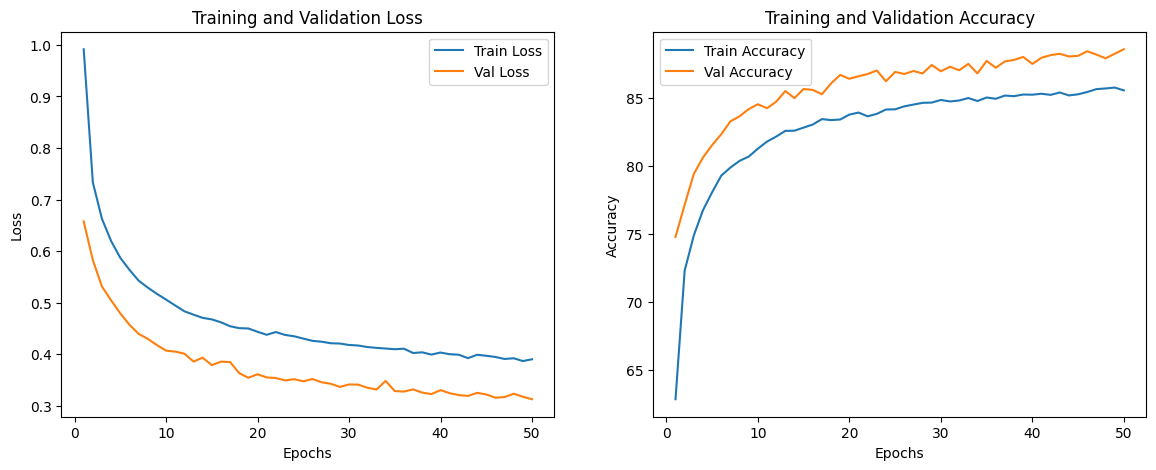

In [10]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

print("Model Training and Validation Metrics:")
print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
print(f"Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Validation Accuracy: {history['val_acc'][-1]:.2f}%")

if max(history['val_acc']) > 90:
    print("The model performs well on the validation set, indicating good generalization.")
else:
    print("The model's performance on the validation set is suboptimal, suggesting potential overfitting or underfitting.")

if history['train_acc'][-1] - history['val_acc'][-1] > 10:
    print("There is a significant gap between training and validation accuracy, indicating potential overfitting.")
else:
    print("The gap between training and validation accuracy is reasonable, indicating good generalization.")

plot_metrics(history)


### Model Evaluation Process

1. **Testing the Model**  
   - Switches the model to evaluation mode.  
   - Iterates through the test data, making predictions and tracking accuracy.  

2. **Performance Metrics**  
   - Calculates overall test accuracy.  
   - Generates a detailed classification report with precision, recall, and F1-score for each class.

3. **Confusion Matrix**  
   - Plots a heatmap to visualize the confusion matrix, highlighting prediction errors and class-wise performance.

4. **Output Summary**  
   - Summarizes the test accuracy and provides insights into the model's strengths and weaknesses across classes.
   

Testing: 100%|██████████| 157/157 [00:01<00:00, 106.21it/s]



Test Accuracy: 90.20%

Classification Report:
              precision    recall  f1-score   support

     T-Shirt       0.84      0.86      0.85      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.81      0.85      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.79      0.89      0.84      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.73      0.68      0.70      1000
     Sneaker       0.93      0.98      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle Boot       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



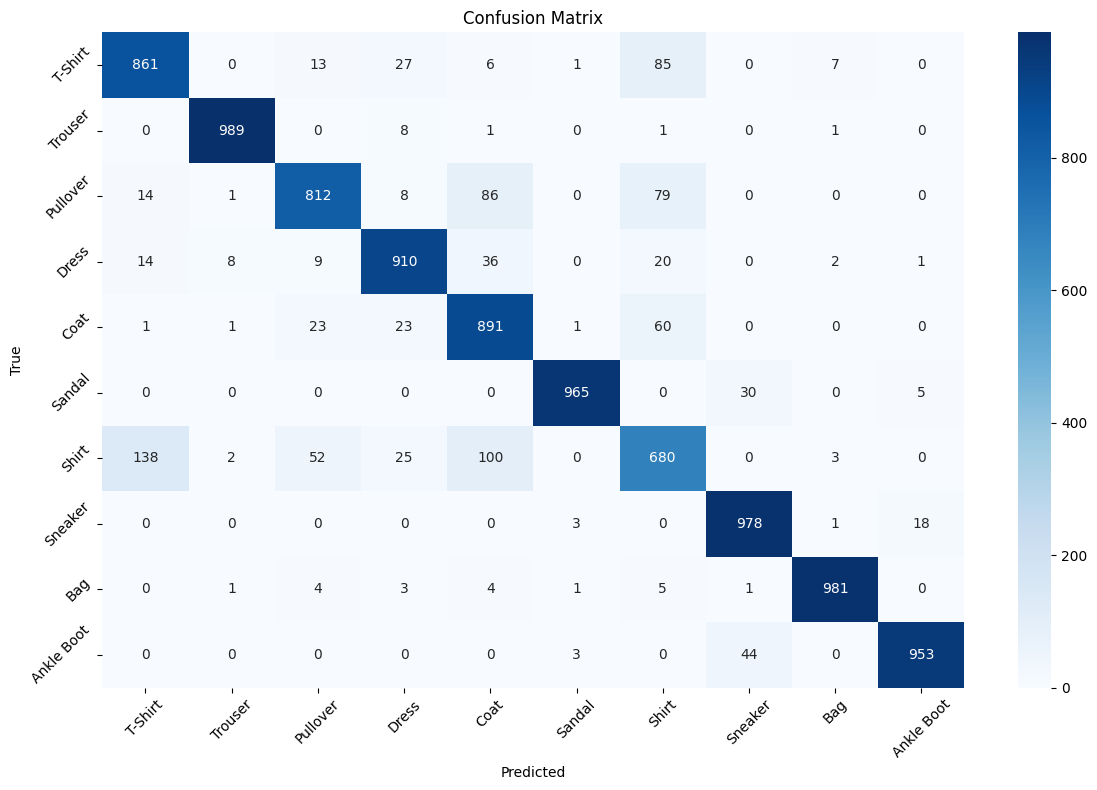

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    print(f'\nTest Accuracy: {test_acc:.2f}%')
    
    # Print classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, 
                              target_names=[labels_map[i] for i in range(10)]))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[labels_map[i] for i in range(10)],
                yticklabels=[labels_map[i] for i in range(10)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return test_acc

test_accuracy = evaluate_model(model, test_loader)

### Image Classification Workflow

1. **Label Mapping**  
   - Maps numeric class indices to descriptive labels (e.g., `0: "T-shirt/top"`).

2. **Image Preprocessing**  
   - Ensures the input image exists and reads it in RGB mode.  
   - Applies transformations:
     - Resizes the image to 28x28 pixels.  
     - Converts it to grayscale.  
     - Normalizes using dataset-specific mean and standard deviation.  
     - Converts the image into a tensor and adds a batch dimension.

3. **Model Loading**  
   - Ensures the model file exists.  
   - Loads the pre-trained model's weights.  
   - Sets the model to evaluation mode.

4. **Prediction**  
   - Runs the model inference with the preprocessed image.  
   - Maps the predicted class index to the corresponding label using `labels_map`.

5. **Error Handling**  
   - Captures and reports errors if the image or model paths are incorrect, or during inference.

6. **Output**  
   - Returns the predicted label for the image.  
   - Prints a failure message if classification fails.

In [12]:
labels_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

def classify_image(model_path, image_path):
    try:
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model not found at {model_path}")

        image = Image.open(image_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))
        ])
        image_tensor = transform(image).unsqueeze(0).to(device)

        model = FashionCNN().to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()

        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted = torch.max(outputs.data, 1)

        return labels_map[predicted.item()]

    except Exception as e:
        print(f"Error during inference: {str(e)}")
        raise

model_path = '/kaggle/working/best_fashion_cnn.pth'
image_path = '/kaggle/input/your-image-png/images Background Removed.png'  # Specify the path to your image

try:
    classification = classify_image(model_path, image_path)
    print(f"The image is classified as: {classification}")
except Exception as e:
    print(f"Failed to classify the image: {str(e)}")


The image is classified as: T-shirt/top


/tmp/ipykernel_23/967234830.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
